# Notebook for Supervised ML: Predicting dynamics

Code generated with: https://chatgpt.com/share/687e8e4d-d5cc-8011-9fb9-76572b71678f

Code of original paper: https://github.com/clegaard/deep_learning_for_dynamical_systems/blob/main/

In [6]:
# --------------------- Import necessary libraries ---------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim

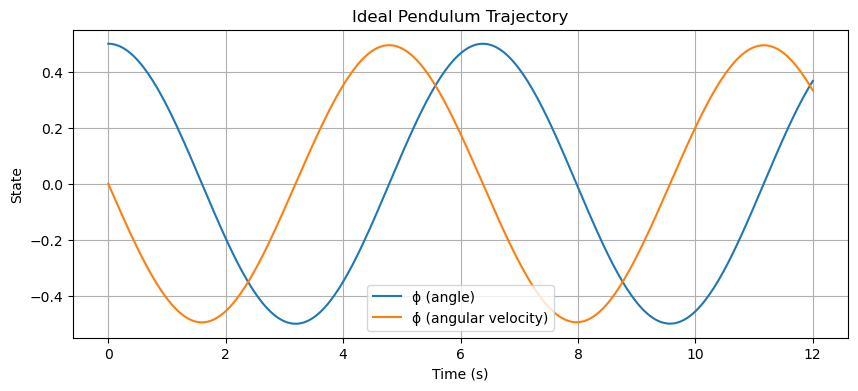

In [8]:
# --------------------- Simulate and plot data ---------------------

g = 1.0      # gravity (m/s^2)
l = 1.0      # pendulum length (m)

t_span = (0, 12)  # total simulation time
t_eval = np.linspace(*t_span, 300)  # times to evaluate

# Initial conditions: phi = 0.5 rad, phi_dot = 0.0 rad/s
x0 = [0.5, 0.0]

# Pendulum ODE system
def pendulum_ode(t, y):
    phi, phi_dot = y
    dphi_dt = phi_dot
    dphi_dot_dt = - (g / l) * np.sin(phi)
    return [dphi_dt, dphi_dot_dt]

# Simulate trajectory
sol = solve_ivp(pendulum_ode, t_span, x0, t_eval=t_eval, method='RK45')
phi, phi_dot = sol.y

# Plot trajectory
plt.figure(figsize=(10, 4))
plt.plot(sol.t, phi, label='ϕ (angle)')
plt.plot(sol.t, phi_dot, label='ϕ̇ (angular velocity)')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.title('Ideal Pendulum Trajectory')
plt.legend()
plt.grid(True)
plt.show()

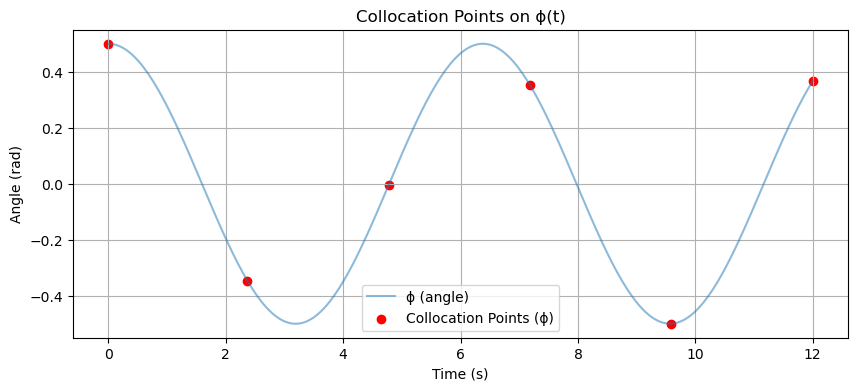

In [10]:
# Select collocation points
num_collocation = 6
collocation_idx = np.linspace(0, len(t_eval)-1, num_collocation, dtype=int)

t_collocation = t_eval[collocation_idx]
phi_collocation = phi[collocation_idx]
phi_dot_collocation = phi_dot[collocation_idx]

# Plot collocation points
plt.figure(figsize=(10, 4))
plt.plot(t_eval, phi, label='ϕ (angle)', alpha=0.5)
plt.scatter(t_collocation, phi_collocation, color='red', label='Collocation Points (ϕ)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Collocation Points on ϕ(t)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# hyperparameters:
epochs = 10000

## Train and evaluate vanilla direct model

In [14]:
# Prepare training data (collocation points)
t_train = torch.tensor(t_collocation, dtype=torch.float32).unsqueeze(1)  # shape (N, 1)
y_train = torch.tensor(np.vstack([phi_collocation, phi_dot_collocation]).T, dtype=torch.float32)  # shape (N, 2)

# Define the network
class VanillaDirectNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Softplus(),
            nn.Linear(32, 32),
            nn.Softplus(),
            nn.Linear(32, 2)  # output: [phi, phi_dot]
        )
    def forward(self, t):
        return self.net(t)

# Instantiate model, optimizer and loss
model = VanillaDirectNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(t_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 0.666614
Epoch 500: Loss = 0.078352
Epoch 1000: Loss = 0.035534
Epoch 1500: Loss = 0.000055
Epoch 2000: Loss = 0.000000
Epoch 2500: Loss = 0.000000
Epoch 3000: Loss = 0.000000
Epoch 3500: Loss = 0.000000
Epoch 4000: Loss = 0.000000
Epoch 4500: Loss = 0.000001
Epoch 5000: Loss = 0.000023
Epoch 5500: Loss = 0.000000
Epoch 6000: Loss = 0.000000
Epoch 6500: Loss = 0.000000
Epoch 7000: Loss = 0.000000
Epoch 7500: Loss = 0.000553
Epoch 8000: Loss = 0.000028
Epoch 8500: Loss = 0.000604
Epoch 9000: Loss = 0.000178
Epoch 9500: Loss = 0.000000


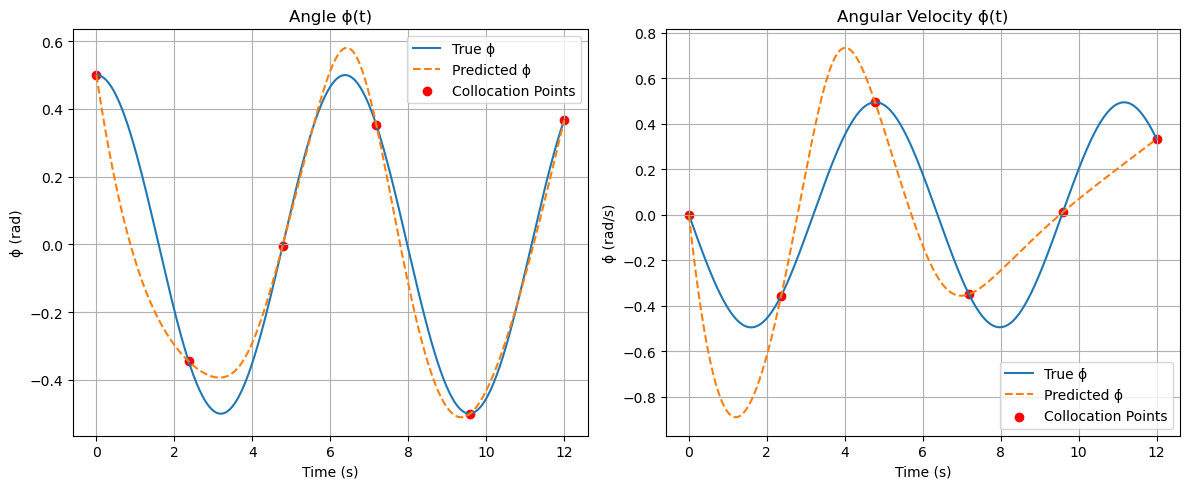

In [16]:
# Evaluate model on full time domain
model.eval()
with torch.no_grad():
    t_full = torch.tensor(t_eval, dtype=torch.float32).unsqueeze(1)
    y_pred = model(t_full).numpy()

# Extract predictions
phi_pred, phi_dot_pred = y_pred.T
phi_direct_pred, phi_dot_direct_pred = y_pred.T

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t_eval, phi, label='True ϕ')
plt.plot(t_eval, phi_pred, '--', label='Predicted ϕ')
plt.scatter(t_collocation, phi_collocation, c='red', label='Collocation Points')
plt.title('Angle ϕ(t)')
plt.xlabel('Time (s)')
plt.ylabel('ϕ (rad)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_eval, phi_dot, label='True ϕ̇')
plt.plot(t_eval, phi_dot_pred, '--', label='Predicted ϕ̇')
plt.scatter(t_collocation, phi_dot_collocation, c='red', label='Collocation Points')
plt.title('Angular Velocity ϕ̇(t)')
plt.xlabel('Time (s)')
plt.ylabel('ϕ̇ (rad/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Auto-differentiation direct model

In [19]:
# Define the network: maps t → phi
class AutoDiffDirectNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Softplus(),
            nn.Linear(32, 32),
            nn.Softplus(),
            nn.Linear(32, 1)  # output: phi only
        )
    def forward(self, t):
        return self.net(t)

# Instantiate model, optimizer and loss
model_ad = AutoDiffDirectNN()
optimizer_ad = optim.Adam(model_ad.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [21]:
# Enable gradient tracking for t
t_train_ad = t_train.clone().detach().requires_grad_(True)
phi_true = torch.tensor(phi_collocation, dtype=torch.float32).unsqueeze(1)
phi_dot_true = torch.tensor(phi_dot_collocation, dtype=torch.float32).unsqueeze(1)

# Training
for epoch in range(epochs):
    model_ad.train()
    optimizer_ad.zero_grad()

    # Predict ϕ
    phi_pred = model_ad(t_train_ad)

    # Compute ϕ̇ = dϕ/dt using autograd
    phi_dot_pred = torch.autograd.grad(
        phi_pred, t_train_ad,
        grad_outputs=torch.ones_like(phi_pred),
        create_graph=True
    )[0]

    # Compute combined loss
    loss_phi = loss_fn(phi_pred, phi_true)
    loss_phi_dot = loss_fn(phi_dot_pred, phi_dot_true)
    loss = loss_phi + loss_phi_dot

    loss.backward()
    optimizer_ad.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 0.289716
Epoch 500: Loss = 0.167229
Epoch 1000: Loss = 0.012669
Epoch 1500: Loss = 0.004735
Epoch 2000: Loss = 0.003975
Epoch 2500: Loss = 0.003541
Epoch 3000: Loss = 0.003520
Epoch 3500: Loss = 0.003273
Epoch 4000: Loss = 0.002968
Epoch 4500: Loss = 0.002607
Epoch 5000: Loss = 0.002458
Epoch 5500: Loss = 0.002304
Epoch 6000: Loss = 0.002144
Epoch 6500: Loss = 0.002000
Epoch 7000: Loss = 0.001864
Epoch 7500: Loss = 0.001887
Epoch 8000: Loss = 0.001645
Epoch 8500: Loss = 0.001444
Epoch 9000: Loss = 0.001253
Epoch 9500: Loss = 0.000843


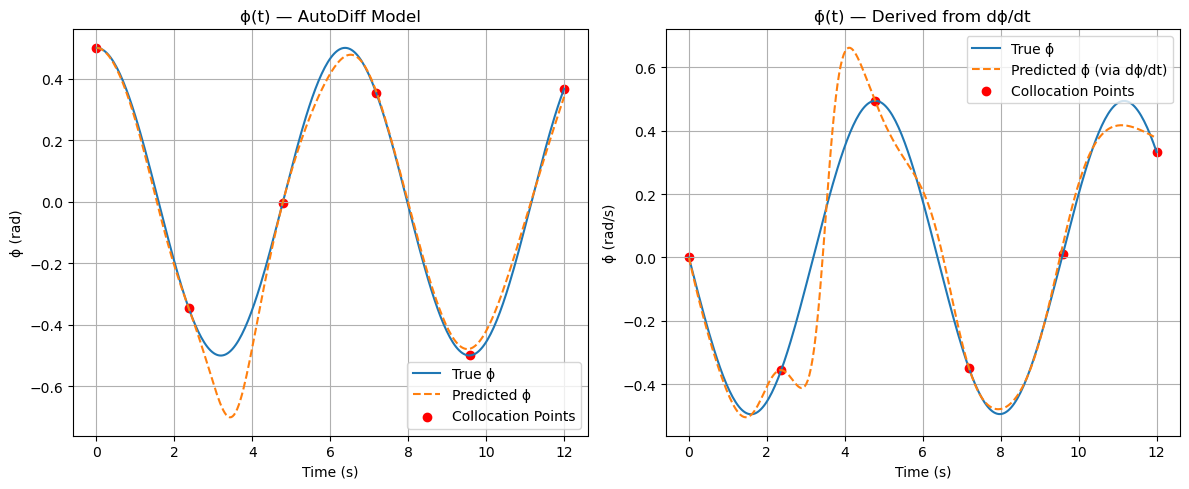

In [23]:
# Evaluate on full time domain
t_full_ad = torch.tensor(t_eval, dtype=torch.float32).unsqueeze(1).requires_grad_(True)

with torch.no_grad():
    phi_full_pred = model_ad(t_full_ad)

# Re-enable gradients for ϕ̇ computation
phi_full_pred = model_ad(t_full_ad)
phi_dot_full_pred = torch.autograd.grad(
    phi_full_pred, t_full_ad,
    grad_outputs=torch.ones_like(phi_full_pred),
    create_graph=False
)[0]

# Convert to NumPy
phi_pred_ad = phi_full_pred.detach().numpy().flatten()
phi_dot_pred_ad = phi_dot_full_pred.detach().numpy().flatten()

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t_eval, phi, label='True ϕ')
plt.plot(t_eval, phi_pred_ad, '--', label='Predicted ϕ')
plt.scatter(t_collocation, phi_collocation, c='red', label='Collocation Points')
plt.title('ϕ(t) — AutoDiff Model')
plt.xlabel('Time (s)')
plt.ylabel('ϕ (rad)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_eval, phi_dot, label='True ϕ̇')
plt.plot(t_eval, phi_dot_pred_ad, '--', label='Predicted ϕ̇ (via dϕ/dt)')
plt.scatter(t_collocation, phi_dot_collocation, c='red', label='Collocation Points')
plt.title('ϕ̇(t) — Derived from dϕ/dt')
plt.xlabel('Time (s)')
plt.ylabel('ϕ̇ (rad/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## PINN

In [26]:
# Reuse previous network that outputs only θ
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Softplus(),
            nn.Linear(32, 32),
            nn.Softplus(),
            nn.Linear(32, 1)
        )
    def forward(self, t):
        return self.net(t)

model_pinn = PINN()
optimizer_pinn = optim.Adam(model_pinn.parameters(), lr=1e-3)

In [28]:
# Inputs for training with gradients
t_train_pinn = t_train.clone().detach().requires_grad_(True)

# Ground-truth values at collocation points
phi_true = torch.tensor(phi_collocation, dtype=torch.float32).unsqueeze(1)
phi_dot_true = torch.tensor(phi_dot_collocation, dtype=torch.float32).unsqueeze(1)

In [30]:
for epoch in range(epochs):
    model_pinn.train()
    optimizer_pinn.zero_grad()

    # Predict ϕ
    phi_pred = model_pinn(t_train_pinn)

    # ϕ̇ = dϕ/dt
    phi_dot_pred = torch.autograd.grad(
        phi_pred, t_train_pinn,
        grad_outputs=torch.ones_like(phi_pred),
        create_graph=True
    )[0]

    # dϕ̇/dt = d²ϕ/dt²
    dphi_dot_dt = torch.autograd.grad(
        phi_dot_pred, t_train_pinn,
        grad_outputs=torch.ones_like(phi_dot_pred),
        create_graph=True
    )[0]

    # Physics-informed residual: dϕ̇/dt + (g/l) * sin(ϕ) = 0
    physics_residual = dphi_dot_dt + (g / l) * torch.sin(phi_pred)

    # Loss terms
    loss_collocation = loss_fn(phi_pred, phi_true) + loss_fn(phi_dot_pred, phi_dot_true)
    loss_physics = loss_fn(physics_residual, torch.zeros_like(physics_residual))

    # Total loss
    loss = loss_collocation + loss_physics

    loss.backward()
    optimizer_pinn.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.6f} | Data = {loss_collocation.item():.6f} | Physics = {loss_physics.item():.6f}")

Epoch 0: Total Loss = 0.785293 | Data = 0.504086 | Physics = 0.281207
Epoch 500: Total Loss = 0.188220 | Data = 0.183055 | Physics = 0.005166
Epoch 1000: Total Loss = 0.158175 | Data = 0.151135 | Physics = 0.007040
Epoch 1500: Total Loss = 0.103387 | Data = 0.095460 | Physics = 0.007927
Epoch 2000: Total Loss = 0.043732 | Data = 0.034002 | Physics = 0.009729
Epoch 2500: Total Loss = 0.029140 | Data = 0.018194 | Physics = 0.010945
Epoch 3000: Total Loss = 0.025677 | Data = 0.014916 | Physics = 0.010761
Epoch 3500: Total Loss = 0.024808 | Data = 0.013843 | Physics = 0.010965
Epoch 4000: Total Loss = 0.024134 | Data = 0.013293 | Physics = 0.010841
Epoch 4500: Total Loss = 0.023450 | Data = 0.012772 | Physics = 0.010678
Epoch 5000: Total Loss = 0.023499 | Data = 0.011772 | Physics = 0.011728
Epoch 5500: Total Loss = 0.022216 | Data = 0.011639 | Physics = 0.010577
Epoch 6000: Total Loss = 0.021425 | Data = 0.011361 | Physics = 0.010064
Epoch 6500: Total Loss = 0.020722 | Data = 0.010936 | P

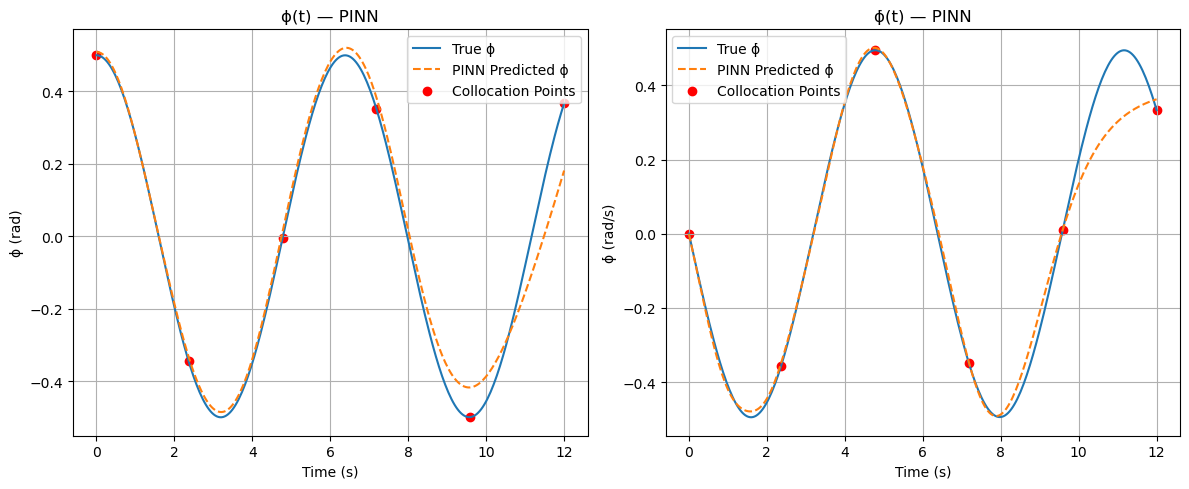

In [33]:
# Evaluation over full time domain
t_full = torch.tensor(t_eval, dtype=torch.float32).unsqueeze(1).requires_grad_(True)
phi_pred_full = model_pinn(t_full)

# ϕ̇ = dϕ/dt
phi_dot_pred_full = torch.autograd.grad(
    phi_pred_full, t_full,
    grad_outputs=torch.ones_like(phi_pred_full),
    create_graph=False
)[0]

phi_pinn = phi_pred_full.detach().numpy().flatten()
phi_dot_pinn = phi_dot_pred_full.detach().numpy().flatten()

phi_pinn_pred = phi_pinn
phi_dot_pinn_pred = phi_dot_pinn

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t_eval, phi, label='True ϕ')
plt.plot(t_eval, phi_pinn, '--', label='PINN Predicted ϕ')
plt.scatter(t_collocation, phi_collocation, c='red', label='Collocation Points')
plt.title('ϕ(t) — PINN')
plt.xlabel('Time (s)')
plt.ylabel('ϕ (rad)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_eval, phi_dot, label='True ϕ̇')
plt.plot(t_eval, phi_dot_pinn, '--', label='PINN Predicted ϕ̇')
plt.scatter(t_collocation, phi_dot_collocation, c='red', label='Collocation Points')
plt.title('ϕ̇(t) — PINN')
plt.xlabel('Time (s)')
plt.ylabel('ϕ̇ (rad/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Plot for article

tensor([[ 0.5000],
        [-0.3457],
        [-0.0047],
        [ 0.3520],
        [-0.4995],
        [ 0.3671]])

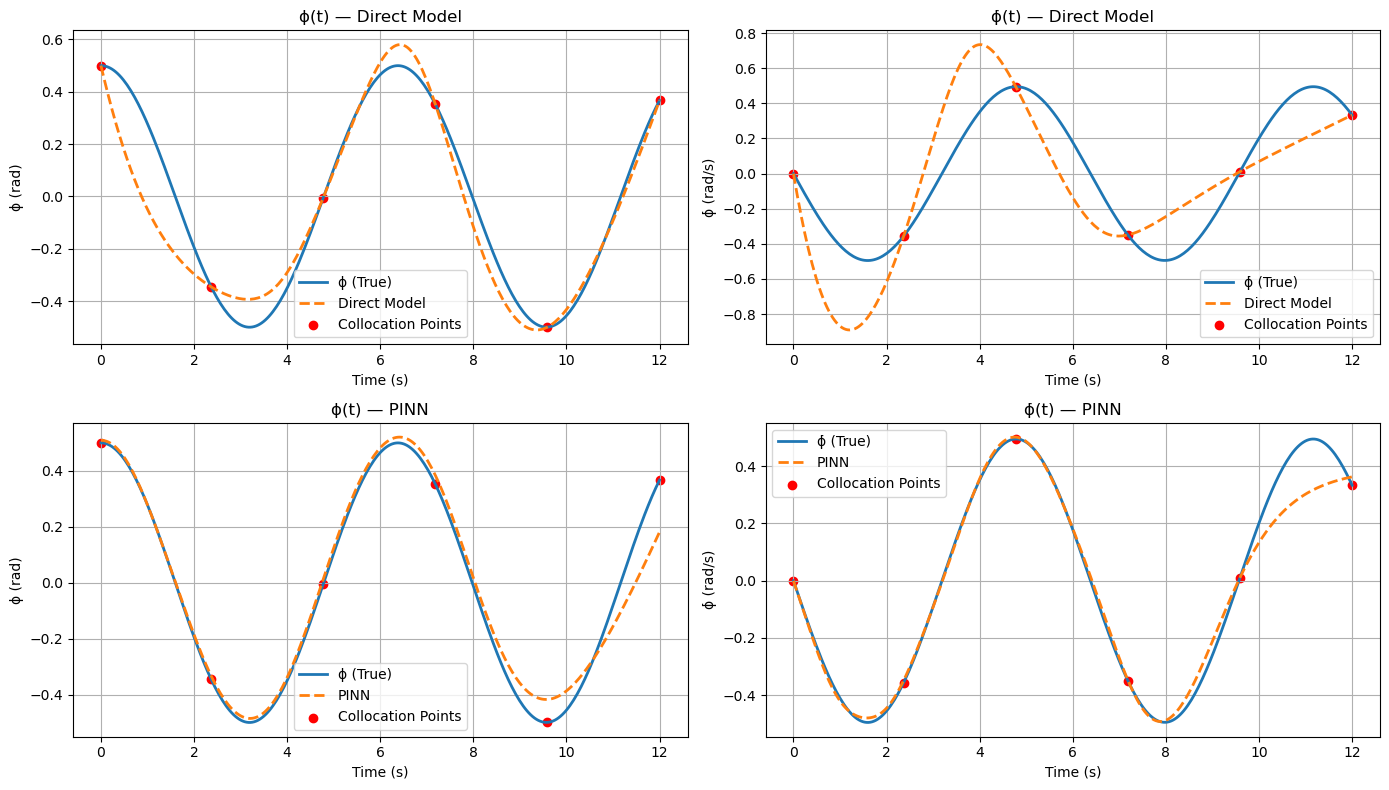

In [74]:
# Ensure all collocation arrays are 1D for plotting
phi_collocation = phi_collocation.flatten()
phi_dot_collocation = phi_dot_collocation.flatten()

# Plot only Direct model and PINN model
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# --- Row 1 (was Row 2): Direct model ---
axs[0, 0].plot(t_eval, phi, label='ϕ (True)', linewidth=2)
axs[0, 0].plot(t_eval, phi_direct_pred, '--', label='Direct Model', linewidth=2)
axs[0, 0].scatter(t_collocation, phi_collocation, c='red', label='Collocation Points')
axs[0, 0].set_title('ϕ(t) — Direct Model')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('ϕ (rad)')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(t_eval, phi_dot, label='ϕ̇ (True)', linewidth=2)
axs[0, 1].plot(t_eval, phi_dot_direct_pred, '--', label='Direct Model', linewidth=2)
axs[0, 1].scatter(t_collocation, phi_dot_collocation, c='red', label='Collocation Points')
axs[0, 1].set_title('ϕ̇(t) — Direct Model')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('ϕ̇ (rad/s)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# --- Row 2 (was Row 3): PINN model ---
axs[1, 0].plot(t_eval, phi, label='ϕ (True)', linewidth=2)
axs[1, 0].plot(t_eval, phi_pinn_pred, '--', label='PINN', linewidth=2)
axs[1, 0].scatter(t_collocation, phi_collocation, c='red', label='Collocation Points')
axs[1, 0].set_title('ϕ(t) — PINN')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('ϕ (rad)')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(t_eval, phi_dot, label='ϕ̇ (True)', linewidth=2)
axs[1, 1].plot(t_eval, phi_dot_pinn_pred, '--', label='PINN', linewidth=2)
axs[1, 1].scatter(t_collocation, phi_dot_collocation, c='red', label='Collocation Points')
axs[1, 1].set_title('ϕ̇(t) — PINN')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('ϕ̇ (rad/s)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust vertical spacing between rows
plt.subplots_adjust(hspace=0.4)  # You can increase this value for more spacing

plt.tight_layout()
plt.show()